# Primer experimento :

## Descripcion :
La primera prueba que se va a realizar es entrenar 1 modelo por secuencia y luego contrastar los resultados contra las demas secuencias.

## Datos de entrada:

Se esta usando la secuencias individuales de la libreria VIDRILO.
Tambien para la transformacion inicial se usa la media de cada dataset que se vaya a usar como modelo , como es una prueba en la que no se va a optimizar el entrenamiento de cada secuencia la media solo se calcula sobre el conjunto con el que se va a entrenar. Ejemplo en el caso de entrenar el model sobre la primera secuencia , la media se calcula sobre esta.

## Ajustes del entrenamiento:

Numero de iteraciones : 35000
Tamaño del mini batch : 25

In [1]:
# Inicializamos las librerias de cafe
import caffe
import lmdb
import numpy as np
import matplotlib.pyplot as plt
from caffe.proto import caffe_pb2
from caffe.io import datum_to_array, array_to_datum

#from sklearn.metrics import confusion_matrix


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
blob = caffe.proto.caffe_pb2.BlobProto()
data = open( '/vol/pfc/data/means/Sequence_2_4_5_oversampel_scikit_learn.binaryproto' , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
out = arr[0]
#np.save( '/vol/pfc/data/means/Sequence_2_4_5_oversampel_scikit_learn_mean.npy', out )

In [3]:
#Funcion que no sirve para hacer la prediccion
def predict(image_in):
    net.blobs['data'].data[...] = image_in
    out = net.forward()
    top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
    output_prob = out['prob'][0]
    #print 'predicted class is:', output_prob.argmax()
    return output_prob.argmax()
    

In [4]:

datum = caffe.proto.caffe_pb2.Datum()
# Caffe en modo gpu para evaluar mas rapido
#caffe.set_mode_gpu()

def load_sequence(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    return lmdb_cursor

def load_model(model_path,deploy_path):
    #deploy_path="/vol/pfc/prototxt/sequence1/train_sequence_25_lmdb_deploy.prototxt"    
    net = caffe.Net(deploy_path,model_path, caffe.TEST)
    return net
   
def load_transform(net,mean_path):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_mean('data', np.load(mean_path).mean(1).mean(1))
    transformer.set_transpose('data', (2,0,1))
    return transformer
    
    

In [5]:
sequences=["/vol/pfc/data/datasets/Sequence1_lmdb","/vol/pfc/data/datasets/Sequence2_lmdb"
           ,"/vol/pfc/data/datasets/Sequence3_lmdb","/vol/pfc/data/datasets/Sequence4_lmdb"
           ,"/vol/pfc/data/datasets/Sequence5_lmdb"]

sequences=["/vol/pfc/data/datasets/Sequence_1_3_lmdb","/vol/pfc/data/datasets/Sequence_2_4_5_oversampel_scikit_learn_lmdb"]

models=["/vol/pfc/data/models/sequence_2_4_5_oversample_25/train_sequence_2_4_5_25_lmdb_iter_35000.caffemodel" ]

means=["/vol/pfc/data/means/Sequence_2_4_5_oversampel_scikit_learn_mean.npy"]

deploys=["/vol/pfc/prototxt/sequence_2_4_5_oversample/train_sequence_25_lmdb_deploy.prototxt"]

In [6]:
caffe.set_mode_cpu()
net=load_model(models[0],deploys[0])
transform=load_transform(net,means[0])

In [7]:
data=load_sequence(sequences[0])

In [8]:
images=[value for key, value in data]

In [15]:
datum.ParseFromString(images[10])
label = datum.label
print label
data = caffe.io.datum_to_array(datum)
print data.shape
image = np.transpose(data,(1, 2, 0))
image= transform.preprocess('data', image)
image.shape



1
(3, 240, 320)


(3, 240, 320)

TypeError: Invalid dimensions for image data

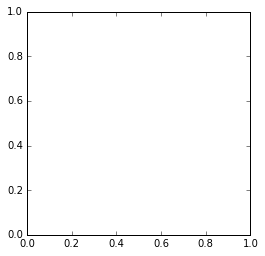

In [12]:
plt.imshow(image)
plt.show()

In [6]:
def process_sequence(net,sequence,transform):
    data_array = []
    cnt=0
    for key, value in sequence:
        datum.ParseFromString(value)
        label = datum.label
        data = caffe.io.datum_to_array(datum)
        image = np.transpose(data,(1, 2, 0))
        prediccion = predict(transform.preprocess('data', image))
        data_array.append((label,prediccion)) 
        #print " label "+str(label)+" preiccion "+str(prediccion)
      #  cnt+=1
      #  if(cnt>100):
      #      break
        
    return data_array
        

In [7]:

len_model=len(models)
len_sequences=len(sequences)
print "inicio"
data_evaluate2=[]
for i in range(0,len_model):
    model=models[i]
    deploy=deploys[i]
    print 'evalua el  modelo: '+str(model)
    net=load_model(model,deploy)
    transform=load_transform(net,means[i])
    data_evaluate2.append([])
    for j in range(0,len_sequences):
        print 'evalua sequence '+str(sequences[j])
        data=load_sequence(sequences[j])
        data_evaluate2[i].append(process_sequence(net,data,transform))
    print "end "+str(model)


inicio
evalua el  modelo: /vol/pfc/data/models/sequence_2_4_5_oversample_25/train_sequence_2_4_5_25_lmdb_iter_35000.caffemodel
evalua sequence /vol/pfc/data/datasets/Sequence_1_3_lmdb
evalua sequence /vol/pfc/data/datasets/Sequence_2_4_5_oversampel_scikit_learn_lmdb
end /vol/pfc/data/models/sequence_2_4_5_oversample_25/train_sequence_2_4_5_25_lmdb_iter_35000.caffemodel


In [8]:
len(data_evaluate2[0])

2

In [9]:
seq_model_label=['seq1_model','seq2_model','seq4_model','seq5_model']
seq_dataset_label=['seq1','seq2','seq3','seq4','seq5']

In [10]:
def get_accuracy(y):
    y_real=y[:,0]
    y_pred=y[:,1]
    metrics= y_real==y_pred
    accuracy =(np.sum(metrics)*100.0)/len(metrics)
    #print "accruracy "+"{:10.4f}".format(accuracy) +"%"
    return "{:10.4f}".format(accuracy)+"%"

In [11]:
len_data_evaluate_model=len(data_evaluate2)

for i in range(0,len_data_evaluate_model):
    len_dataset_evaluate=len(data_evaluate2[i])
    seq_for_model=data_evaluate2[i]
    print "model "+seq_model_label[i]
    result_line=""
    for j in range(0,len_dataset_evaluate):
        result_line+=" "+seq_dataset_label[j]+": "+(get_accuracy(np.array(seq_for_model[j])))
    
    print result_line
                            
                                       

model seq1_model
 seq1:     7.3108% seq2:     9.9769%


## Tiempo de entrenamiento:

El tiempo de entrenamiento esta desde 3h y 3 minutos a 4 horas depende del tamaño de la secuencia

In [2]:

y=data_evaluate2[0]
y_real=y[:,0]
y_pred=y[:,1]
confusion_matrix(y_real, y_pred)

NameError: name 'data_evaluate2' is not defined